In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import functions as fn

## Plot of the Surface

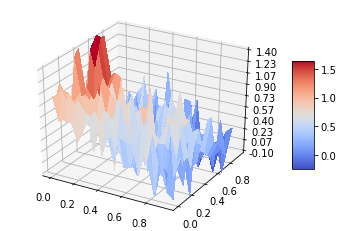

In [2]:
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)
z = fn.FrankeFunction(x, y, 0.3)


fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Part a) Ordinary Least Squares on the data set

### Perform a OLS regression using polynomials in x and y up to fifth order. 
### Find the confidence interval nof the estimators $\beta$
### Use the MSE- and R2 score functions.  
### Scalind of the data, split of the data. 

In [3]:
# Initializing the data
N = 70
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)
z = fn.FrankeFunction(x_, y_, 0.3)
z = np.ravel(z)

# Creating the design matrix
n=5 
X = fn.create_X(x_, y_, n)
        
# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Inverting XTX matrix with SVD to avoid singular matrix
XTXinv = fn.SVDinv(X_train.T.dot(X_train))


# Estimating the Ordinary Least Squares Beta Matrix
OLSbeta = XTXinv.dot(X_train.T).dot(z_train)

# Making the prediciton
z_tilde = X_train @ OLSbeta
z_predict = X_test @ OLSbeta




print("The MSE for the prediciton is:")
print(fn.MSE(z_test, z_predict), "\n")

print("The R2 for the prediciton is:")
print(fn.R2(z_test, z_predict), "\n")

The MSE for the prediciton is:
0.09482007088446093 

The R2 for the prediciton is:
0.4967110992032834 



## Beta coefficents and their 95% confidence intervals

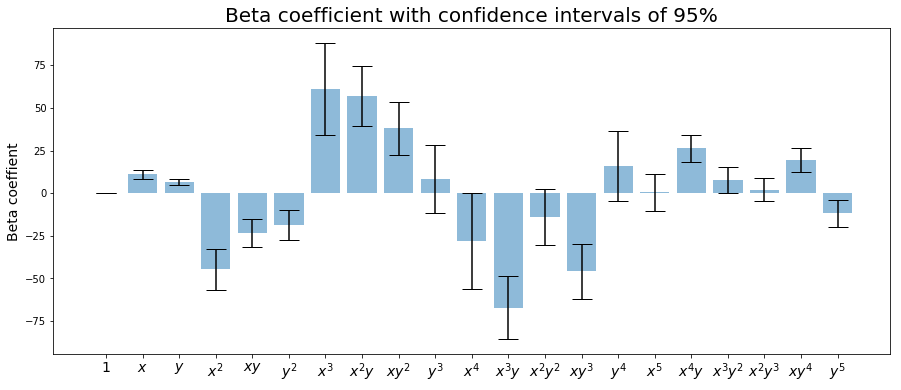

In [5]:
# Calculating the variance
betavariance = np.sqrt(np.diagonal(XTXinv)*np.var(z_train-z_tilde))

# Plotting the figure

fig, ax = plt.subplots(figsize=(15,6))

labels= ['1','$x$','$y$','$x^2$','$xy$','$y^2$','$x^3$','$x^2y$','$xy^2$','$y^3$','$x^4$',
         '$x^3y$','$x^2y^2$','$xy^3$','$y^4$','$x^5$','$x^4y$','$x^3y^2$','$x^2y^3$','$xy^4$','$y^5$']

x_pos = np.arange(len(OLSbeta))
ax.bar(x_pos, OLSbeta, yerr=2*betavariance, alpha=0.5,capsize=10)
ax.set_ylabel('Beta coeffient', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=14)
ax.set_title('Beta coefficient with confidence intervals of 95%', fontsize=20)

plt.show()

## Visual Help:
### Plotting function on $[0,1]\times[0,1]$ using the Beta coefficients

In [5]:
def PredictPlot(OLSbeta, N,n, title='Prectided FrankeFunction', savefig=False):
    # Plotting 
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    x_,y_ = np.meshgrid(x,y)

    X = fn.create_X(x_,y_,n)
    Z = X @ OLSbeta
    Z=Z.reshape(N,N)
    
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x_, y_, Z, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)

    plt.title(title)
    
    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if savefig == True:
        plt.savefig(title+".png")
    plt.show()

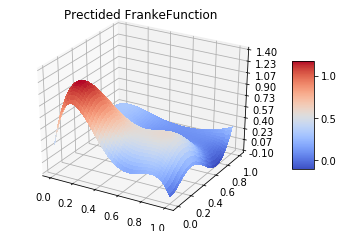

In [6]:
PredictPlot(OLSbeta,100,5)

# Part b): Bias-variance trade-off and resampling techniques.

### Make a figure similar to Fig. 2.11 of Hasties, et al., with only the testing and training MSEs.
### Show that the cost function
### $C(\mathbf{X}, \mathbf{\beta}) = \frac{1}{n}\sum_{i=0}^{n-1}(y_i -\tilde{y_i})^2 = \mathbb{E}[(\mathbf{y}-\mathbf{\tilde{y}})^2] $
### can be rewritten as 
### $\mathbb{E}[(\mathbf{y}-\mathbf{\tilde{y}})^2] = \frac{1}{n}\sum_{i} (f_i -\mathbb{E}[\mathbf{\tilde{y}}])^2 +  \frac{1}{n}\sum_{i}(y_i -\mathbb{E}[\mathbf{\tilde{y}}])^2 + \sigma^2$

### Explain the terms, which one is bias and variance and their interpretations

### Perform bias variance tradeoff with increasing polynomials (model complexity) and number of data points, and bootstrap resampling methods on the training and testing data

In [8]:
N = 70
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.3)
z = np.ravel(z)

# Array of polynomial degrees
n=np.arange(30)
X = fn.create_X(x_,y_,n[-1])

print(X.shape, z.shape)


# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Creating arrays for train and test error
TrainError = np.zeros(n.shape)
TestError = np.zeros(n.shape)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

for i in range(len(n)):

    # How many columns of the design matrix allowed.
    q = int((i+1)*(i+2)/2)
    X_trainD = X_train[:,:q]
    X_testD = X_test[:,:q]

    
    # Inverting XTX matrix with SVD to avoid singular matrix
    XTXinv = fn.SVDinv(X_trainD.T.dot(X_trainD))
    
    # Estimating the Ordinary Least Squares Beta Matrix
    OLSbeta = XTXinv.dot(X_trainD.T).dot(z_train)

    # Making the prediciton
    z_tilde = X_trainD @ OLSbeta
    z_predict = X_testD @ OLSbeta


    TrainError[i] = fn.MSE(z_train, z_tilde)
    TestError[i] = fn.MSE(z_test, z_predict)
    


(4900, 465) (4900,)


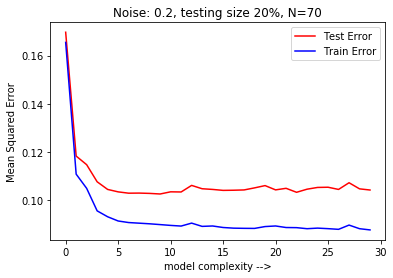

In [9]:
startpoint = 0
endpoint = 30
plt.plot(n[startpoint:endpoint],TestError[startpoint:endpoint],'r' ,label='Test Error')
plt.plot(n[startpoint:endpoint],TrainError[startpoint:endpoint],'b' ,label='Train Error')
plt.xlabel('model complexity -->')
plt.ylabel('Mean Squared Error')
plt.title("Noise: 0.2, testing size 20%, N=70")

plt.legend()

## Perform bias variance tradeoff with increasing polynomials (model complexity) and number of data points, and bootstrap resampling methods on the training and testing data

### Incorporating bootstrap techniques

In [10]:
# Initalizing
N = 30
n = np.arange(30)

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Creating design matrix for the maximum polynomial degree. 
X = fn.create_X(x_,y_,n[-1])

# Test Train splitting of data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

# Intializing error bias and variance
error = np.zeros(n.shape)
bias = np.zeros(n.shape)
variance = np.zeros(n.shape)

# Bootstrap parameters
n_bootstraps = 100

for i in range(len(n)):
    # How many columns of the design matrix allowed.
    q = int((i+1)*(i+2)/2)
    X_trainD = X_train[:,:q]
    X_testD = X_test[:,:q]

    # Setting up the array for the bootstrapped predictions
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        x_, z_  = fn.Shuffle_Data(X_trainD, z_train)
        OLSbeta = fn.SVDinv(x_.T.dot(x_)).dot(x_.T).dot(z_) 
        z_pred[:,j] = X_testD @ OLSbeta 

    #Reshaping
    z_test = z_test.reshape(len(z_test),1)
    
    
    error[i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

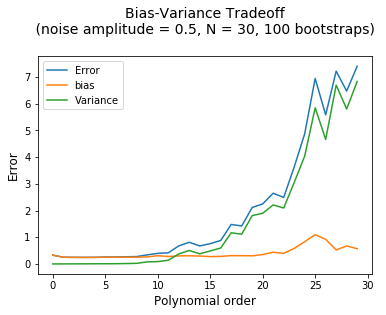

In [11]:
startpoint = 0
endpoint = 30


plt.plot(n[startpoint:endpoint], error[startpoint:endpoint], label='Error')
plt.plot(n[startpoint:endpoint], bias[startpoint:endpoint], label='bias')
plt.plot(n[startpoint:endpoint], variance[startpoint:endpoint], label='Variance')
plt.legend()
plt.ylabel("Error", fontsize=12)
plt.xlabel("Polynomial order",  fontsize=12)
plt.title("Bias-Variance Tradeoff\n (noise amplitude = 0.5, N = 30, 100 bootstraps) \n", fontsize =14)
plt.savefig("biasvariance.png", dpi=100)

plt.show()


## Cross-Validation as resampling techniques, adding more complexity.

In [12]:
# Initalizing
N = 70
n=np.arange(30)

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Creating design matrix for the maximum polynomial degree. 
X = fn.create_X(x_,y_,n[-1])

# Splitting into testing and training data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

# Intializing error bias and variance
error = np.zeros(n.shape)
bias = np.zeros(n.shape)
variance = np.zeros(n.shape)

# CV fold parameters 
folds = 5
foldsize = np.int(len(X_train)/folds)

for i in range(len(n)):
    # How many columns of the design matrix allowed.
    q = int((i+1)*(i+2)/2)
    X_trainD = X_train[:,:q]
    X_testD = X_test[:,:q]

    # Setting up the array for the CV-fold predictions
    z_pred = np.empty((z_test.shape[0], folds))
    
    for j in range(folds):

        # Reshuffling the data
        # x_, z_ = Shuffle_Data(X_trainD, z_train)
        x_ = X_trainD
        z_ = z_train
        
        x_ = x_[(foldsize*j):(foldsize*(j+1)),:]
        z_ = z_[(foldsize*j):(foldsize*(j+1))]
        
        # Computing the beta matrix on the fold
        OLSbeta = fn.SVDinv(x_.T.dot(x_)).dot(x_.T).dot(z_) 
        z_pred[:,j] = X_testD @ OLSbeta 

    #Reshaping
    z_test = z_test.reshape(len(z_test),1)
    
    error[i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

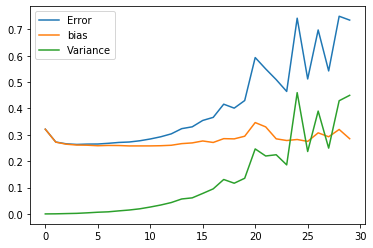

In [13]:
startpoint = 0
endpoint = 30

plt.plot(n[startpoint:endpoint], error[startpoint:endpoint], label='Error')
plt.plot(n[startpoint:endpoint], bias[startpoint:endpoint], label='bias')
plt.plot(n[startpoint:endpoint], variance[startpoint:endpoint], label='Variance')
plt.legend()
plt.show()

## Ridge Regression on the Franke funcion with resampling

### Perform Ridge Regression with either matrix inversion or SVD.
### Use bootstrap for the same polynomial range as in b), and cross-valdiation as in c), but plotted for different values of $\lambda$

### Bootstrapping:

In [7]:
# Initalizing
N = 30
n = np.arange(30)

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Creating design matrix for the maximum polynomial degree. 
X = fn.create_X(x_,y_,n[-1])

# Test Train splitting of data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

# Lambda
lamb = 10**np.linspace(-13,1,15)

# Bootstrap parameters
n_bootstraps = 50


# Intializing error bias and variance
error = np.zeros((len(lamb),len(n)))
bias = np.zeros((len(lamb),len(n)))
variance = np.zeros((len(lamb),len(n)))



for k in range(len(lamb)):
        for i in range(len(n)):
            # How many columns of the design matrix allowed.
            q = int((i+1)*(i+2)/2)
            X_trainD = X_train[:,:q]
            X_testD = X_test[:,:q]

            # Setting up the array for the bootstrapped predictions
            z_pred = np.empty((z_test.shape[0], n_bootstraps))

            for j in range(n_bootstraps):
                x_, z_  = fn.Shuffle_Data(X_trainD, z_train)
                RIDGEbeta = fn.SVDinv(x_.T.dot(x_)+lamb[k]*np.eye(q)).dot(x_.T).dot(z_) 
                z_pred[:,j] = X_testD @ RIDGEbeta 

            #Reshaping
            z_test = z_test.reshape(len(z_test),1)


            error[k,i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
            bias[k,i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
            variance[k,i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

In [8]:
print(np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) ))
print(np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 ))
print(np.mean( np.var(z_pred, axis=1, keepdims=True) ))

0.24294599659971744
0.23753081088987718
0.005415185709840254


In [6]:
def betaplot(OLSbeta):
    x_pos = np.arange(len(OLSbeta))
    ax.bar(x_pos, OLSbeta, alpha=0.5,capsize=10)
    ax.set_ylabel('Beta coeffient', fontsize=14)
    ax.set_xticks(x_pos)
    #ax.set_xticklabels(labels, fontsize=14)
    ax.set_title('Beta coefficient with confidence intervals of 95%', fontsize=20)

    plt.show()

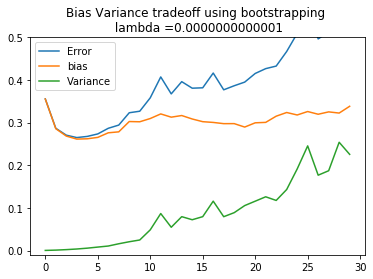

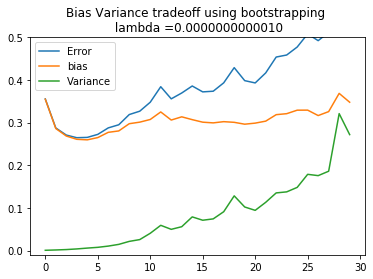

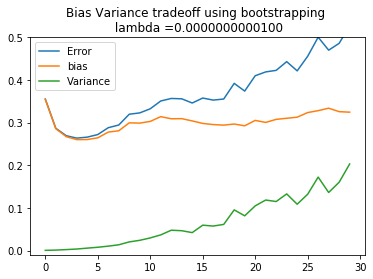

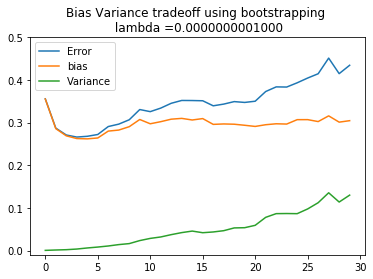

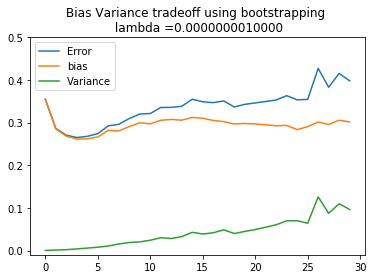

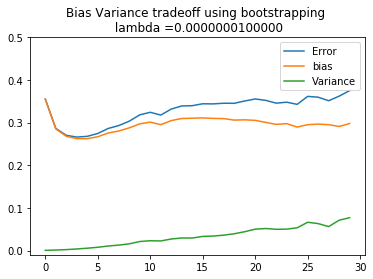

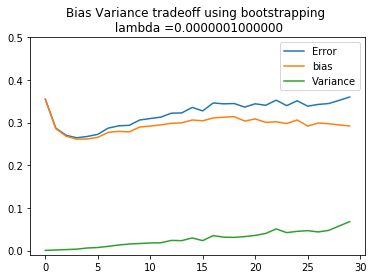

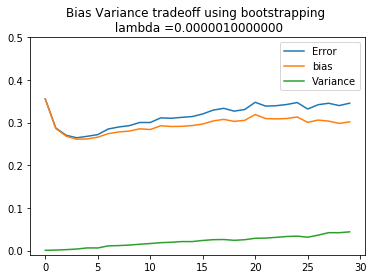

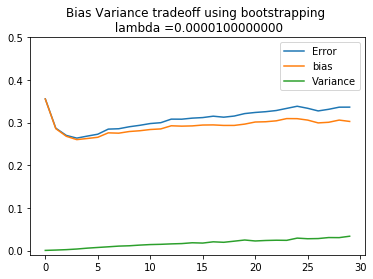

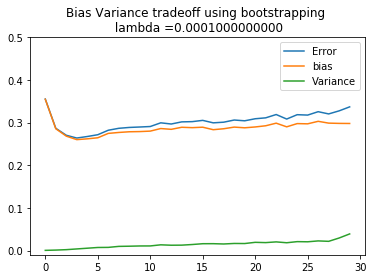

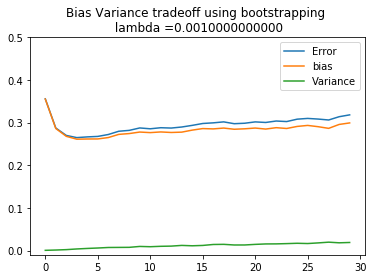

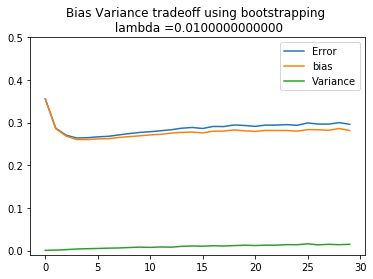

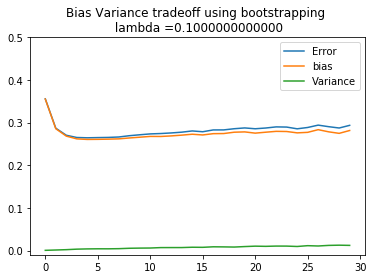

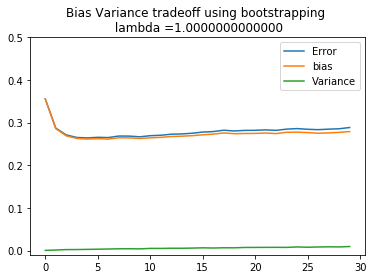

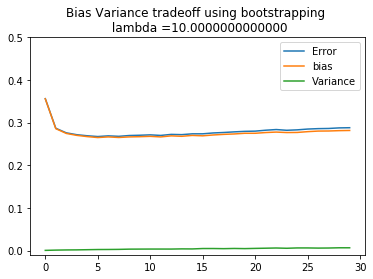

In [99]:
startpoint = 0
endpoint = 30

for k in range(len(lamb)):
    

    plt.plot(n[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    plt.plot(n[startpoint:endpoint], bias[k,startpoint:endpoint], label='bias')
    plt.plot(n[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')
    plt.title("Bias Variance tradeoff using bootstrapping \n lambda =%.13f" % lamb[k])
    plt.legend()
    plt.ylim(-0.01, 0.5)
    plt.show()

In [ ]:
## 

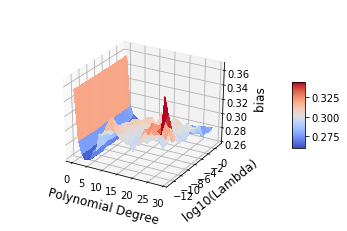

In [100]:

loglamb = np.log10(lamb)
n_, loglamb_  = np.meshgrid(n, loglamb)


fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(n_, loglamb_, bias, label='error', cmap=cm.coolwarm,
                        linewidth=5, antialiased=False)
plt.title("")

# Changing the size of the plot
#fig_size[0]=20
#fig_size[1]=12
#plt.rcParams["figure.figsize"] = fig_size

# Changing the viewing distance
ax.dist = 13

# axis labels

ax.set_xlabel('\n Polynomial Degree', fontsize=12, rotation=150)
ax.set_ylabel('\n log10(Lambda)', fontsize=12, rotation=150)
ax.set_zlabel('\n bias', fontsize=12, rotation=150)
#ax.yaxis.set_scale('log')

# Customize the z axis.
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.3, aspect=5)
plt.show()

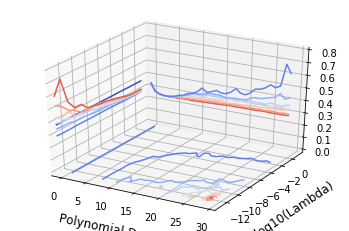

In [104]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

loglamb = np.log10(lamb)
n_, loglamb_  = np.meshgrid(n, loglamb)

fig = plt.figure()
ax = fig.gca(projection='3d')

#ax.plot_surface(n_, loglamb_, error, rstride=120, cstride=120, alpha=0.2)

cset = ax.contour(n_, loglamb_, error, zdir='z', offset=-0.01, cmap=cm.coolwarm)
cset = ax.contour(n_, loglamb_, error, zdir='x', offset=-2, cmap=cm.coolwarm)
cset = ax.contour(n_, loglamb_, error, zdir='y', offset=np.max(loglamb), cmap=cm.coolwarm)

ax.set_xlabel('\n Polynomial Degree', fontsize=12, rotation=150)
ax.set_ylabel('\n log10(Lambda)', fontsize=12, rotation=150)
ax.set_zlabel('\n Error', fontsize=12, rotation=150)
ax.set_zlim(-0.01, 0.8)

#cbar = plt.colorbar(cset)
#cbar.solids.set_edgecolor("face")



plt.show()







## e) Lasso Regression on the Franke function with resampling

### Perform Lasso Regression with Scikit-Learn.
### Use bootstrap for the same polynomial range as in b), and cross-valdiation as in c), but plotted for different values of $\lambda$
### Give a critical discussion of the three methods and a judgement of which model fits the data best.

In [20]:
from sklearn import linear_model

# Initalizing
N = 30
n = np.arange(15)

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Creating design matrix for the maximum polynomial degree. 
X = fn.create_X(x_,y_,n[-1])

# Test Train splitting of data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

# Lambda
lamb = 10**np.linspace(-7,1,8)

# Bootstrap parameters
n_bootstraps = 10


# Intializing error bias and variance
error = np.zeros((len(lamb),len(n)))
bias = np.zeros((len(lamb),len(n)))
variance = np.zeros((len(lamb),len(n)))



for k in range(len(lamb)):
        for i in range(len(n)):
            # How many columns of the design matrix allowed.
            q = int((i+1)*(i+2)/2)
            X_trainD = X_train[:,:q]
            X_testD = X_test[:,:q]

            # Setting up the array for the bootstrapped predictions
            z_pred = np.empty((z_test.shape[0], n_bootstraps))

            for j in range(n_bootstraps):
                x_, z_  = fn.Shuffle_Data(X_trainD, z_train)
                clf = linear_model.Lasso(alpha=lamb[k], fit_intercept=False)
                clf.fit(x_, z_)
                LASSObeta = clf.coef_
                z_pred[:,j] = X_testD @ LASSObeta 

            #Reshaping
            z_test = z_test.reshape(len(z_test),1)


            error[k,i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
            bias[k,i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
            variance[k,i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )



C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.40696688331415, tolerance: 0.03712060743271564
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.16156802132757, tolerance: 0.03802635293226671
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.7359967246056, tolerance: 0.03615289279048191
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.27592149688596, tolerance: 0.03679043919456846
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.41085679586618, tolerance: 0.03848686330552235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.04018530133739, tolerance: 0.040408543938451114
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obj

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.19792572871953, tolerance: 0.03843911920001232
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.76959868977954, tolerance: 0.04001778426271496
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.53594282399335, tolerance: 0.0372694741288621
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objec

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.09576032186327, tolerance: 0.03608625376638997
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.35253350918313, tolerance: 0.03622846116845045
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.43910290826514, tolerance: 0.03921794616315317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.5118705400128, tolerance: 0.03892203556540401
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.50799963850196, tolerance: 0.03893116880645069
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.42333229704771, tolerance: 0.03742516808488618
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objec

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.87644732743496, tolerance: 0.03819889004424541
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.76737285789568, tolerance: 0.0399207978234719
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.23662562127939, tolerance: 0.03883324544708909
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objec

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.05113610613483, tolerance: 0.03821251104868039
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.54270765821144, tolerance: 0.03808135908495693
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.78983432692195, tolerance: 0.03553455891393336
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.54477943003887, tolerance: 0.03535513138385656
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.37055991001068, tolerance: 0.03878937828170149
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.24424041589404, tolerance: 0.03912713144559992
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.25377129685687, tolerance: 0.0398239581562896
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.39662733037278, tolerance: 0.042851833281495715
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.91825684462286, tolerance: 0.03696787494361244
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obj

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.56513650289158, tolerance: 0.03478983703877622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.49912561148696, tolerance: 0.039067603014178325
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.72228761976372, tolerance: 0.03997082323744492
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obj

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.84551653570294, tolerance: 0.03778301414850758
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.40674143832737, tolerance: 0.0357079288435771
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.41685393966844, tolerance: 0.036925233201883303
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.588494442826203, tolerance: 0.03746094541647907
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.832314244247044, tolerance: 0.040229778195365204
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.184477335924754, tolerance: 0.04069761028650713
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.73788193563885, tolerance: 0.042286033068471694
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.89695777122794, tolerance: 0.03821461478786907
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.749361499183856, tolerance: 0.04009600715809755
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Ob

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.683066339272045, tolerance: 0.04038335524261447
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.13273208638754, tolerance: 0.037401690305583955
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.78732203061443, tolerance: 0.0392550471541141
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obj

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.66910651330027, tolerance: 0.03791149340835471
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.900101904529855, tolerance: 0.0382488782237039
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.09192796449273, tolerance: 0.037256658445250224
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obj

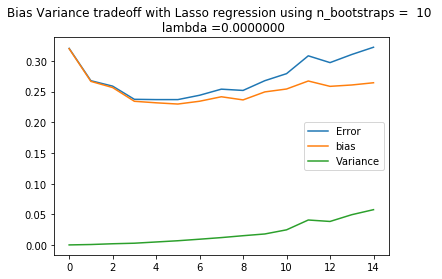

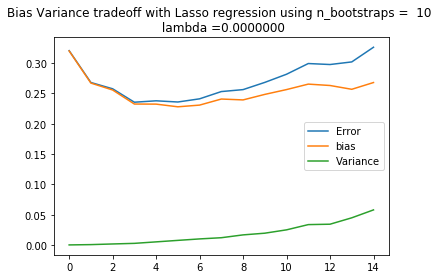

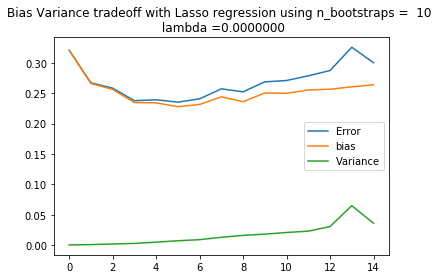

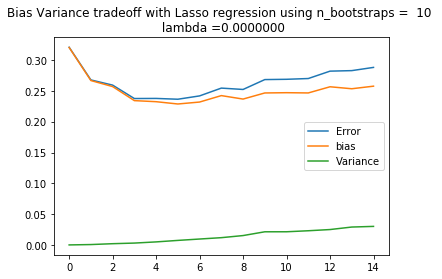

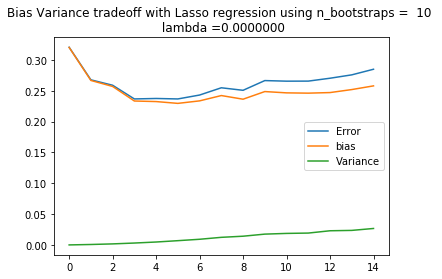

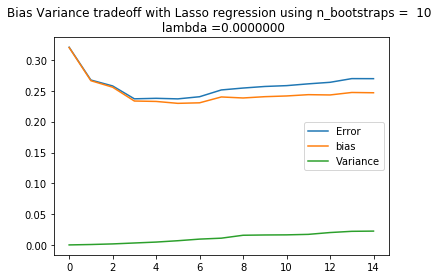

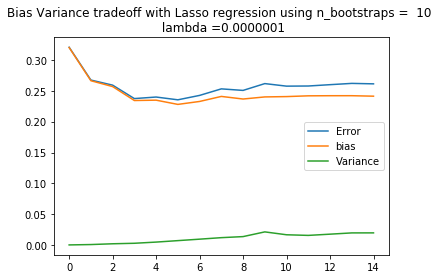

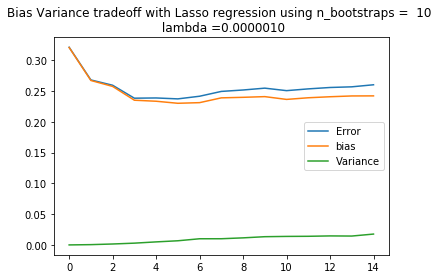

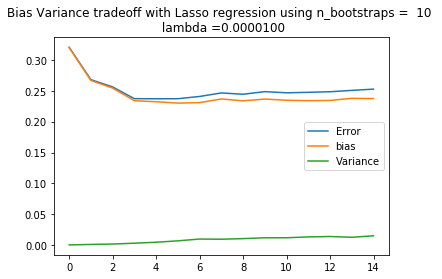

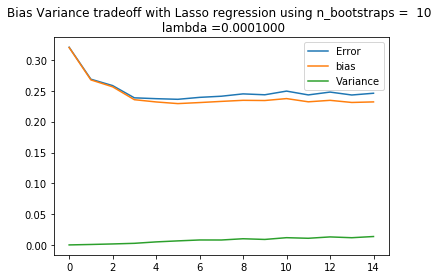

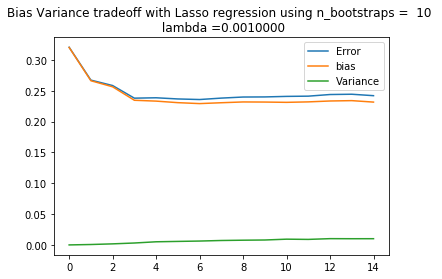

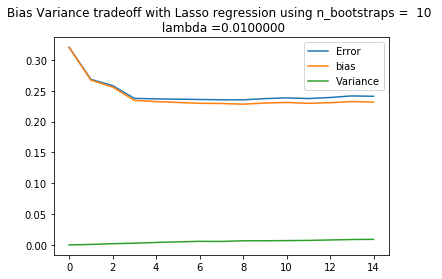

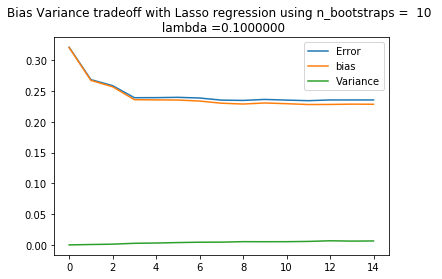

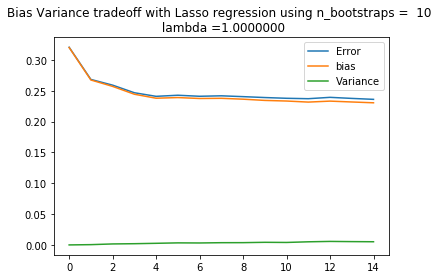

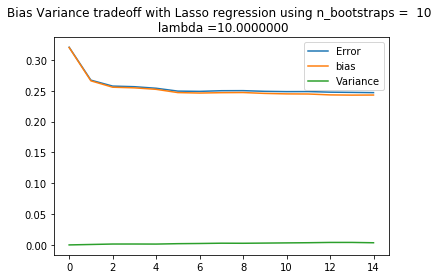

In [10]:
startpoint = 0
endpoint = 15
for k in range(len(lamb)):
    plt.plot(n[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    plt.plot(n[startpoint:endpoint], bias[k,startpoint:endpoint], label='bias')
    plt.plot(n[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')
    plt.title("Bias Variance tradeoff with Lasso regression using n_bootstraps =  10 \n lambda =%.07f" % lamb[k])
    plt.legend()
    #plt.ylim(-0.01, 0.2)
    plt.show()

## f) Introducing real data and preparing the data analysis

### Get data from dta folder of project 1. 

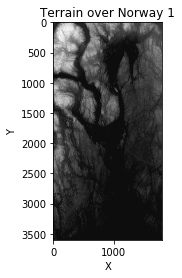

In [16]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Load the terrain
terrain1 = imread("SRTM_data_lahelle.tif")
# Show the terrain
plt.figure()
plt.title("Terrain over Norway 1")
plt.imshow(terrain1, cmap="gray")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [19]:
imarray = np.array(terrain1)


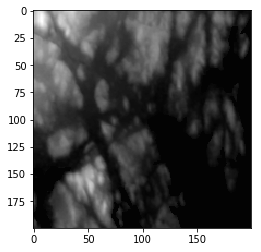

In [37]:
plt.imshow(terrain1[3000:3200, 400:600], cmap="gray")

In [25]:
imarray.shape

(3601, 1801)

In [27]:
imarray[3000:3100, 400:500]

array([[ 96, 100, 107, ...,  56,  58,  59],
       [ 97, 103, 109, ...,  59,  63,  64],
       [100, 106, 110, ...,  64,  67,  69],
       ...,
       [ 57,  57,  57, ...,   7,   6,   6],
       [ 55,  55,  56, ...,  10,   6,   5],
       [ 55,  55,  56, ...,  13,   7,   4]], dtype=int16)

## g) OLS, Ridge and Lasso regression with resampling

### Apply all three methods on the terrain data, with the same polynomial approximation and cross-validation as resampling technique to evaluate which model fits the data best.
### "Present a critical evaluation of your results and disucss the applicability of these regreesion methods to the type of the data presented here (either the terrain data we propose or other data sets)."

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()